In [2]:
import math
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
df = pd.read_csv('./data/tr_eikon_eod_data.csv', index_col = 0, parse_dates = True)

In [4]:
data = df[['AAPL.O','MSFT.O','INTC.O','AMZN.O','GS.N']].dropna()
AAPL = data['AAPL.O']
MSFT = data['MSFT.O']
INTC = data['INTC.O']
AMZN = data['AMZN.O']
GS = data['GS.N']

In [5]:
def get_pre(raw, order):
    
    def arima_forecast(traindata, obs):
        model = ARIMA(traindata, order=order).fit()
        pre_y = model.forecast()[0]
        traindata.append(obs)  # Update traindata with the new observation
        return pre_y
    
    # Split data into training data and testing data
    values = raw.values
    size = int(len(values) * 0.8)
    train = values[:size]
    test = values[size:len(values)]
    
    trainl = train.tolist()
    predictions = []
    for obs in test:
        pre_y = arima_forecast(trainl, obs)
        predictions.append(pre_y)
    
    return predictions

In [105]:
def generate_signals(prices, true_price, pct_within=0.05):
    signals = np.zeros(len(prices))
    for i in range(1, len(prices)):
        prev_price = true_price[i - 1]
        current_price = prices[i]
        upper_bound = prev_price * (1 + pct_within)
        lower_bound = prev_price * (1 - pct_within)
        
        if current_price >= lower_bound and current_price <= upper_bound:
            if signals[i - 1] == 0:
                signals[i] = 1 if current_price > prev_price else -1
            else:
                signals[i] = signals[i - 1]
        elif current_price > upper_bound:
            signals[i] = 1  # Buy signal
        elif current_price < lower_bound:
            signals[i] = -1  # Sell signal
    
    return signals

## AAPL

In [6]:
AAPL_Train = AAPL[:int(len(AAPL) * 0.8)]
AAPL_Test = AAPL[int(len(AAPL) * 0.8):]

In [7]:
# to find the best order (p, d, q)
bestmodel = auto_arima(AAPL_Train, seasonal=False, trace=True).order

Performing stepwise search to minimize aic


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5860.243, Time=2.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5863.226, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5864.599, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5864.563, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5863.676, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5866.270, Time=0.46 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5868.582, Time=1.32 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5869.037, Time=1.16 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5869.029, Time=1.90 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5866.263, Time=0.76 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5867.467, Time=0.93 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5868.093, Time=0.20 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.67 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=5860.693, Time=1.13 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 13.433 seconds


In [22]:
pre_AAPL = get_pre(AAPL, (0,1,1))

In [23]:
pre_AAPL

[117.54796048776961,
 117.46831268565064,
 117.11245827537034,
 117.05886388640916,
 116.59005858387296,
 117.67278733784302,
 118.26252651632774,
 115.53333241294608,
 114.45670750043685,
 113.70349211686117,
 113.53632947620304,
 111.44384229007304,
 111.59327742223981,
 109.79060698330107,
 108.8182467447123,
 110.44567543404612,
 111.07396570241346,
 110.875594457437,
 107.71924230795348,
 108.44572424923716,
 105.6512447383349,
 107.1393061519958,
 110.05148786512105,
 109.94782474729409,
 110.06240999441125,
 111.76593394284394,
 111.80073403815295,
 111.21769046827129,
 111.802279569539,
 111.56502675371402,
 111.45775020288174,
 110.4998826291207,
 109.46802259196109,
 109.90933883034359,
 109.09281165951079,
 109.96823105764597,
 111.05291046756315,
 112.14341882344173,
 113.99078202068829,
 113.28469977162246,
 115.23135780434218,
 115.18910427999349,
 115.83366950371612,
 115.97295735388023,
 116.65448971900278,
 116.9564374679251,
 117.06225729484167,
 116.27318641931362,
 

In [89]:
print(len(pre_AAPL))
print(len(AAPL_Test))

428
428


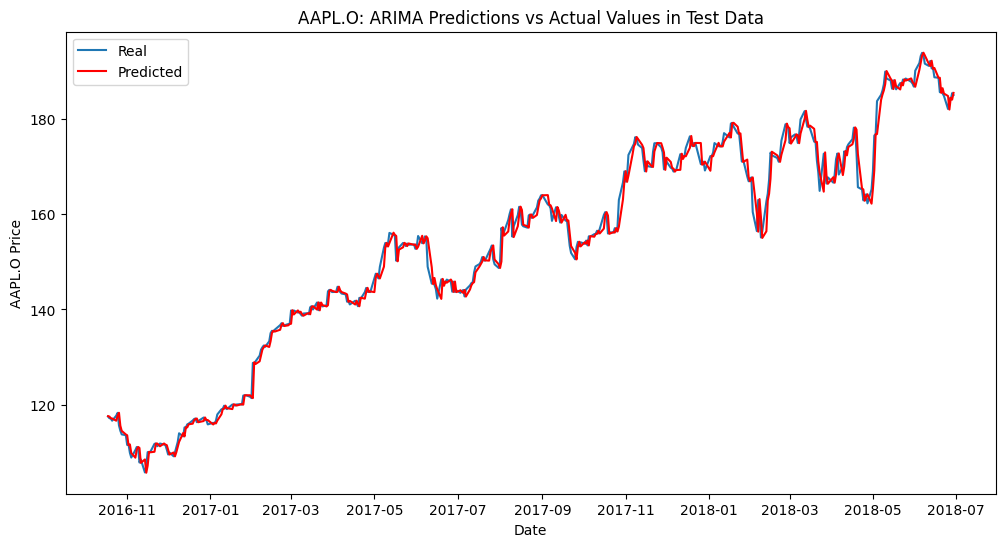

In [9]:
# Compare the test data with predictions
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(AAPL_Test, label='Real')
plt.plot(AAPL_Test.index, pre_AAPL, color='red', label='Predicted')
plt.title('AAPL.O: ARIMA Predictions vs Actual Values in Test Data')
plt.xlabel('Date')
plt.ylabel('AAPL.O Price')
plt.legend()
plt.show()

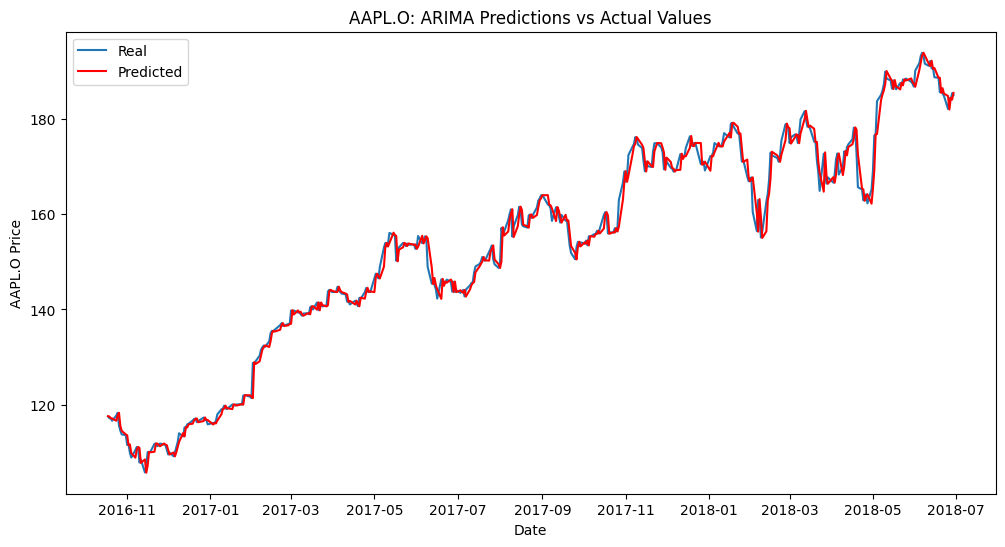

In [10]:
# Compare AAPL.O prices with predictions
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(AAPL_Test, label='Real')
plt.plot(AAPL_Test.index, pre_AAPL, color='red', label='Predicted')
plt.title('AAPL.O: ARIMA Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('AAPL.O Price')
plt.legend()
plt.show()

In [12]:
AAPL_Test = pd.DataFrame(AAPL_Test.dropna())
AAPL_Test['Returns'] = np.log(AAPL_Test['AAPL.O'] / AAPL_Test['AAPL.O'].shift(1))
AAPL_Test['direction'] = np.sign(AAPL_Test['Returns']).dropna().astype(int)
AAPL_Test['prediction']= pre_AAPL

In [91]:
signals = generate_signals(pre_AAPL, AAPL_Test['AAPL.O'])
AAPL_Test['signals'] = signals

/var/folders/2b/tgv3r4pj32b_81f22_mtv7bh0000gn/T/ipykernel_20398/4286599706.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prev_price = true_price[i - 1]


In [92]:
AAPL_Test['strategy'] = AAPL_Test['signals'] * AAPL_Test['Returns']
AAPL_Test[['Returns', 'strategy']].sum().apply(np.exp)

Returns     1.575807
strategy    0.634596
dtype: float64

In [101]:
pre_AAPL

[117.54796048776961,
 117.46831268565064,
 117.11245827537034,
 117.05886388640916,
 116.59005858387296,
 117.67278733784302,
 118.26252651632774,
 115.53333241294608,
 114.45670750043685,
 113.70349211686117,
 113.53632947620304,
 111.44384229007304,
 111.59327742223981,
 109.79060698330107,
 108.8182467447123,
 110.44567543404612,
 111.07396570241346,
 110.875594457437,
 107.71924230795348,
 108.44572424923716,
 105.6512447383349,
 107.1393061519958,
 110.05148786512105,
 109.94782474729409,
 110.06240999441125,
 111.76593394284394,
 111.80073403815295,
 111.21769046827129,
 111.802279569539,
 111.56502675371402,
 111.45775020288174,
 110.4998826291207,
 109.46802259196109,
 109.90933883034359,
 109.09281165951079,
 109.96823105764597,
 111.05291046756315,
 112.14341882344173,
 113.99078202068829,
 113.28469977162246,
 115.23135780434218,
 115.18910427999349,
 115.83366950371612,
 115.97295735388023,
 116.65448971900278,
 116.9564374679251,
 117.06225729484167,
 116.27318641931362,
 

In [102]:
AAPL_Test['AAPL.O']

Date
2016-10-18    117.47
2016-10-19    117.12
2016-10-20    117.06
2016-10-21    116.60
2016-10-24    117.65
               ...  
2018-06-25    182.17
2018-06-26    184.43
2018-06-27    184.16
2018-06-28    185.50
2018-06-29    185.11
Name: AAPL.O, Length: 428, dtype: float64

In [110]:
signals_1pct = generate_signals(pre_AAPL, AAPL_Test['AAPL.O'], .0001)
AAPL_Test['signals_1pct'] = signals_1pct
AAPL_Test['strategy_1pct'] = AAPL_Test['signals_1pct'] * AAPL_Test['Returns']
AAPL_Test[['Returns', 'strategy_1pct']].sum().apply(np.exp)

/var/folders/2b/tgv3r4pj32b_81f22_mtv7bh0000gn/T/ipykernel_20398/4286599706.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prev_price = true_price[i - 1]


Returns          1.575807
strategy_1pct    1.579071
dtype: float64

<Axes: xlabel='Date'>

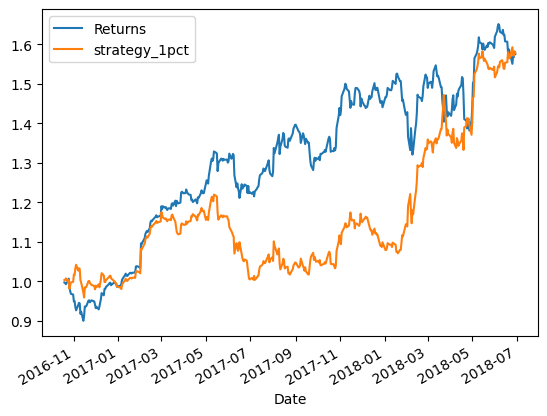

In [123]:
AAPL_Test[['Returns', 'strategy_1pct']].cumsum().apply(np.exp).plot()

## MSFT

In [33]:
MSFT_Train = MSFT[:int(len(AAPL) * 0.8)]
MSFT_Test = MSFT[int(len(AAPL) * 0.8):]

In [34]:
# to find the best order (p, d, q)
bestmodel = auto_arima(MSFT_Train, seasonal=False, trace=True).order

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2868.600, Time=0.75 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2860.659, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2862.604, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2862.604, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2859.955, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2864.607, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.345 seconds


In [35]:
pre_MSFT = get_pre(MSFT, (0,1,1))

In [36]:
pre_MSFT

[57.21870631682393,
 57.662736762567526,
 57.52919157317353,
 57.248280207672906,
 59.6718280313311,
 61.014262576337735,
 60.98973886587579,
 60.62611235645656,
 60.09413221833513,
 59.867451781441304,
 59.92059652055807,
 59.79863224943354,
 59.42578884104671,
 59.207503600104786,
 58.70414378180505,
 60.43764682337743,
 60.470334364237516,
 60.166881510426045,
 58.68357683450754,
 59.02344872763575,
 58.11130606165854,
 58.876344577979815,
 59.65737096736874,
 60.65063253520303,
 60.34691212836408,
 60.86513986049789,
 61.12261253964497,
 60.392836324640676,
 60.53133406787276,
 60.6107672802255,
 61.094707438589076,
 60.25241185637584,
 59.18866583330479,
 59.25065304605547,
 60.23046490359698,
 59.94711551485481,
 61.38346227047853,
 61.006834654981766,
 61.97759839185448,
 62.17157920598599,
 62.98688369559446,
 62.677525890023574,
 62.5792079082795,
 62.29771777582122,
 63.629931529441464,
 63.539345480954594,
 63.54000477819685,
 63.55007296987103,
 63.23773804957764,
 63.28030

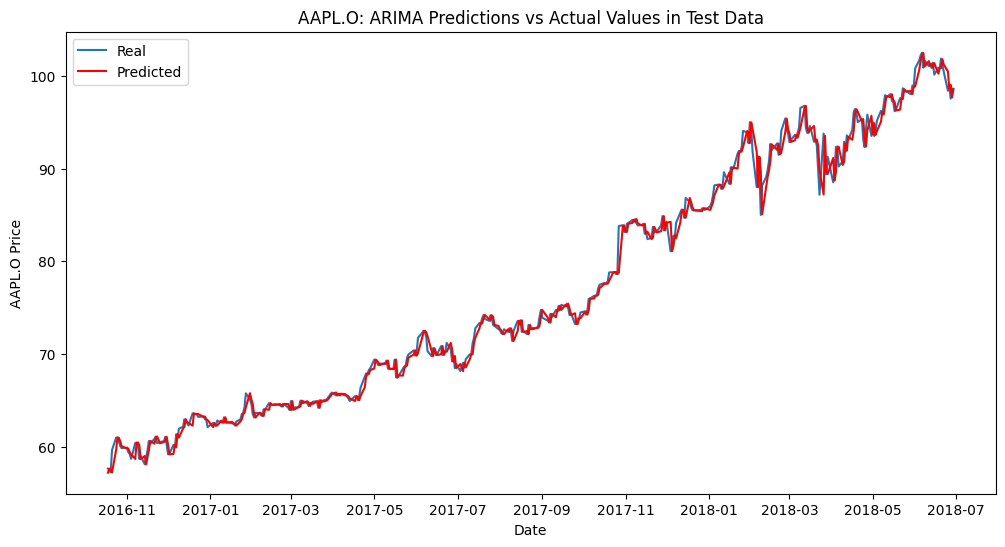

In [37]:
# Compare the test data with predictions
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(MSFT_Test, label='Real')
plt.plot(MSFT_Test.index, pre_MSFT, color='red', label='Predicted')
plt.title('AAPL.O: ARIMA Predictions vs Actual Values in Test Data')
plt.xlabel('Date')
plt.ylabel('AAPL.O Price')
plt.legend()
plt.show()

In [38]:
MSFT_Test = pd.DataFrame(MSFT_Test.dropna())
MSFT_Test['Returns'] = np.log(MSFT_Test['MSFT.O'] / MSFT_Test['MSFT.O'].shift(1))
MSFT_Test['direction'] = np.sign(MSFT_Test['Returns']).dropna().astype(int)
MSFT_Test['prediction']= pre_MSFT

In [119]:
signals = generate_signals(pre_MSFT, MSFT_Test['MSFT.O'], 0.001)
MSFT_Test['signals'] = signals

/var/folders/2b/tgv3r4pj32b_81f22_mtv7bh0000gn/T/ipykernel_20398/4286599706.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prev_price = true_price[i - 1]


In [120]:
MSFT_Test['strategy'] = MSFT_Test['signals'] * MSFT_Test['Returns']
MSFT_Test[['Returns', 'strategy']].sum().apply(np.exp)

Returns     1.710198
strategy    1.805567
dtype: float64

In [41]:
signals_1pct = generate_signals(pre_MSFT, 0.01)
MSFT_Test['signals_1pct'] = signals_1pct
MSFT_Test['strategy_1pct'] = MSFT_Test['signals_1pct'] * MSFT_Test['Returns']
MSFT_Test[['Returns', 'strategy_1pct']].sum().apply(np.exp)

Returns          1.710198
strategy_1pct    0.968692
dtype: float64

<Axes: xlabel='Date'>

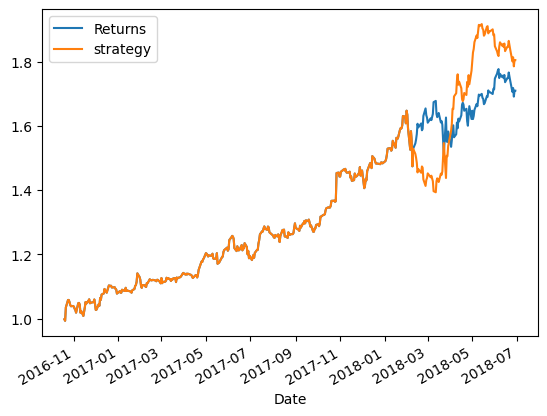

In [121]:
MSFT_Test[['Returns', 'strategy']].cumsum().apply(np.exp).plot()

## INTC

In [150]:
INTC_Train = INTC[:int(len(INTC) * 0.8)]
INTC_Test = INTC[int(len(INTC) * 0.8):]
print(len(INTC_Test))

428


In [46]:
# to find the best order (p, d, q)
bestmodel = auto_arima(INTC_Train, seasonal=False, trace=True).order

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1690.307, Time=3.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1685.908, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1686.842, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1686.846, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1684.913, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1688.843, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.976 seconds


In [47]:
pre_INTC = get_pre(INTC, (0,1,1))

In [148]:
len(pre_INTC)

428

In [151]:
len(INTC_Test)

428

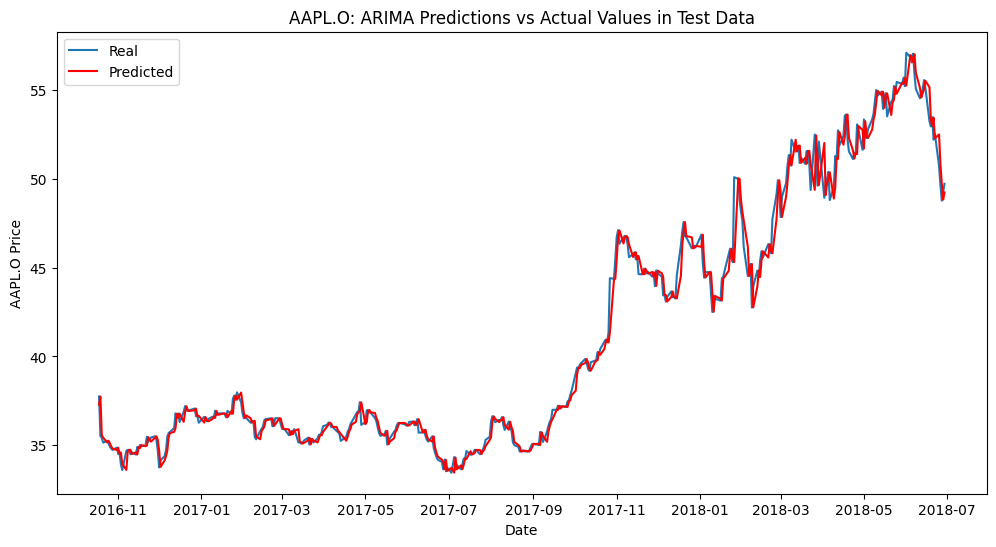

In [49]:
# Compare the test data with predictions
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(INTC_Test, label='Real')
plt.plot(INTC_Test.index, pre_INTC, color='red', label='Predicted')
plt.title('AAPL.O: ARIMA Predictions vs Actual Values in Test Data')
plt.xlabel('Date')
plt.ylabel('AAPL.O Price')
plt.legend()
plt.show()

In [152]:
INTC_Test = pd.DataFrame(INTC_Test.dropna())
INTC_Test['Returns'] = np.log(INTC_Test['INTC.O'] / INTC_Test['INTC.O'].shift(1))
INTC_Test['direction'] = np.sign(INTC_Test['Returns']).dropna().astype(int)
INTC_Test['prediction']= pre_INTC

In [154]:
pre_INTC[50:]

[36.64151580551509,
 36.65951308533292,
 36.280271238806435,
 36.59143363118377,
 36.41489776899179,
 36.35174975087176,
 36.47653784117212,
 36.60640518759787,
 36.54179072983638,
 36.93895465492705,
 36.71626626360123,
 36.787976993685845,
 36.79967011387762,
 36.761088559581445,
 36.57523847057278,
 36.929912105810295,
 36.77445332254899,
 37.59606921570551,
 37.79436385789259,
 37.56653553793327,
 37.968334002650515,
 37.435891400865096,
 36.83713303567235,
 36.52859864603219,
 36.67586427128263,
 36.52427101670765,
 36.27693332582672,
 36.348003162458376,
 36.379125605508634,
 35.48521701732311,
 35.34390554789585,
 35.78757623235176,
 35.92615463021009,
 36.046662379213075,
 36.40026651362574,
 36.47787298130627,
 36.518876250980696,
 36.08200529489584,
 36.177366008416904,
 36.52055234487706,
 36.51028273577363,
 36.20831690878162,
 35.93737410602426,
 35.910724578991335,
 35.900283940082716,
 35.57874008504448,
 35.794090993750004,
 35.624672658757106,
 35.81473476839101,
 35.9

In [155]:
INTC_Test['INTC.O'][50:]

Date
2016-12-29    36.66
2016-12-30    36.27
2017-01-03    36.60
2017-01-04    36.41
2017-01-05    36.35
              ...  
2018-06-25    50.71
2018-06-26    49.67
2018-06-27    48.76
2018-06-28    49.25
2018-06-29    49.71
Name: INTC.O, Length: 378, dtype: float64

In [175]:
signals = generate_signals(pre_INTC, INTC_Test['INTC.O'], 0)
INTC_Test['signals'] = signals

/var/folders/2b/tgv3r4pj32b_81f22_mtv7bh0000gn/T/ipykernel_20398/4286599706.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prev_price = true_price[i - 1]


In [176]:
INTC_Test['strategy'] = INTC_Test['signals'] * INTC_Test['Returns']
INTC_Test[['Returns', 'strategy']].sum().apply(np.exp)

Returns     1.316821
strategy    1.872627
dtype: float64

In [162]:
signals_1pct = generate_signals(pre_INTC, INTC_Test['INTC.O'], 0.01)
INTC_Test['signals_1pct'] = signals_1pct
INTC_Test['strategy_1pct'] = INTC_Test['signals_1pct'] * INTC_Test['Returns']
INTC_Test[['Returns', 'strategy_1pct']].sum().apply(np.exp)

/var/folders/2b/tgv3r4pj32b_81f22_mtv7bh0000gn/T/ipykernel_20398/4286599706.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prev_price = true_price[i - 1]


Returns          1.316821
strategy_1pct    0.759405
dtype: float64

<Axes: xlabel='Date'>

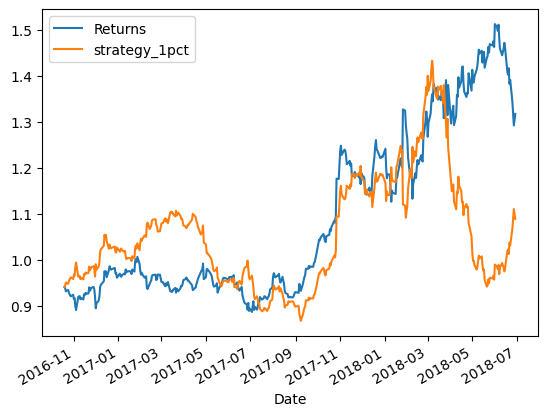

In [54]:
INTC_Test[['Returns', 'strategy_1pct']].cumsum().apply(np.exp).plot()

## AMZN

In [187]:
AMZN_Train = AMZN[:int(len(AMZN) * 0.8)]
AMZN_Test = AMZN[int(len(AMZN) * 0.8):]

In [188]:
# to find the best order (p, d, q)
bestmodel = auto_arima(AMZN_Train, seasonal=False, trace=True).order

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11490.883, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11492.853, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11492.853, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11494.427, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11494.879, Time=0.28 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 2.743 seconds


In [189]:
pre_AMZN = get_pre(AMZN, (0,1,1))

In [190]:
pre_AMZN

[812.8757596778652,
 817.682829348362,
 817.6900493552324,
 810.2692443711711,
 819.0433053047382,
 838.2445313582233,
 835.1573421429725,
 822.4905098492769,
 818.3247919101184,
 775.8778249685037,
 789.8708971372512,
 785.396582289063,
 765.4796575722069,
 767.0357029575008,
 755.0083859359518,
 784.9105481804803,
 787.7508845275723,
 771.8831243021476,
 742.227550571125,
 738.9900768428234,
 718.932031599116,
 743.2767445460196,
 746.4976118625661,
 756.427010083814,
 760.1716937855917,
 780.0781591854687,
 785.3566178417187,
 780.0949417035704,
 780.3713118369452,
 766.7057213833251,
 762.4976614829712,
 750.4998463415499,
 743.6037169510671,
 740.3171464312244,
 759.4807785491059,
 764.7587390990642,
 770.4637542723372,
 767.3063763167772,
 768.6701437180742,
 760.0570124188635,
 774.4263384912875,
 768.7909863770234,
 760.9558911263933,
 757.7511243834297,
 766.0466136109543,
 771.2515942540974,
 770.5960420159745,
 766.3140048318022,
 760.5535499235845,
 771.4618734680937,
 772.

In [197]:
AMZN_Test['AMZN.O']

Date
2016-10-18     817.65
2016-10-19     817.69
2016-10-20     810.32
2016-10-21     818.99
2016-10-24     838.09
               ...   
2018-06-25    1663.15
2018-06-26    1691.09
2018-06-27    1660.51
2018-06-28    1701.45
2018-06-29    1699.80
Name: AMZN.O, Length: 428, dtype: float64

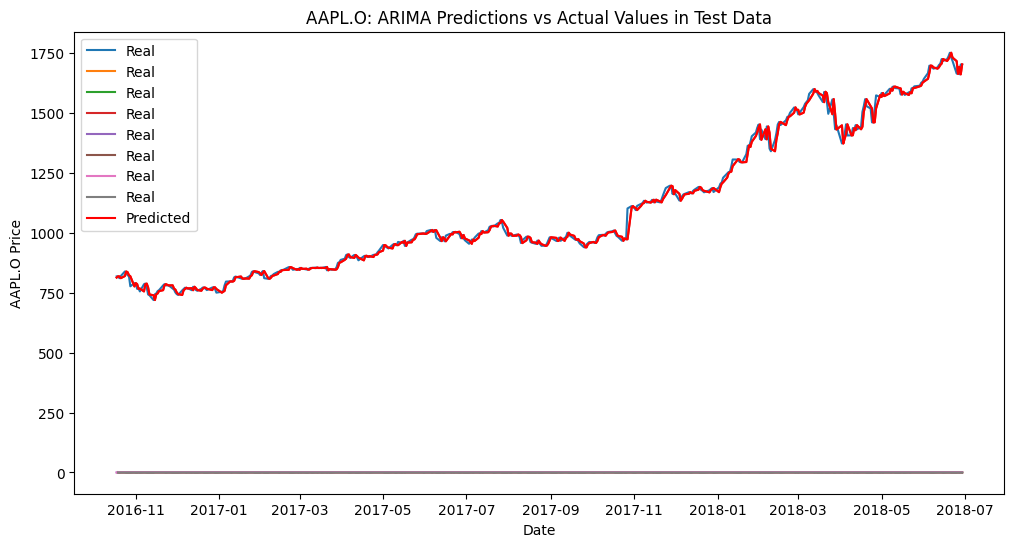

In [198]:
# Compare the test data with predictions
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(AMZN_Test, label='Real')
plt.plot(AMZN_Test.index, pre_AMZN, color='red', label='Predicted')
plt.title('AAPL.O: ARIMA Predictions vs Actual Values in Test Data')
plt.xlabel('Date')
plt.ylabel('AAPL.O Price')
plt.legend()
plt.show()

In [192]:
AMZN_Test = pd.DataFrame(AMZN_Test.dropna())
AMZN_Test['Returns'] = np.log(AMZN_Test['AMZN.O'] / AMZN_Test['AMZN.O'].shift(1))
AMZN_Test['direction'] = np.sign(AMZN_Test['Returns']).dropna().astype(int)
AMZN_Test['prediction']= pre_AMZN

In [193]:
signals = generate_signals(pre_AMZN, AMZN_Test['AMZN.O'], 0.01)
AMZN_Test['signals'] = signals

/var/folders/2b/tgv3r4pj32b_81f22_mtv7bh0000gn/T/ipykernel_20398/4286599706.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prev_price = true_price[i - 1]


In [194]:
AMZN_Test['strategy'] = AMZN_Test['signals'] * AMZN_Test['Returns']
AMZN_Test[['Returns', 'strategy']].sum().apply(np.exp)

Returns     2.078885
strategy    2.078885
dtype: float64

In [195]:
signals_1pct = generate_signals(pre_AMZN, AMZN_Test['signals'], 0.01)
AMZN_Test['signals_1pct'] = signals_1pct
AMZN_Test['strategy_1pct'] = AMZN_Test['signals_1pct'] * AMZN_Test['Returns']
AMZN_Test[['Returns', 'strategy_1pct']].sum().apply(np.exp)

/var/folders/2b/tgv3r4pj32b_81f22_mtv7bh0000gn/T/ipykernel_20398/4286599706.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prev_price = true_price[i - 1]


Returns          2.078885
strategy_1pct    2.078885
dtype: float64

<Axes: xlabel='Date'>

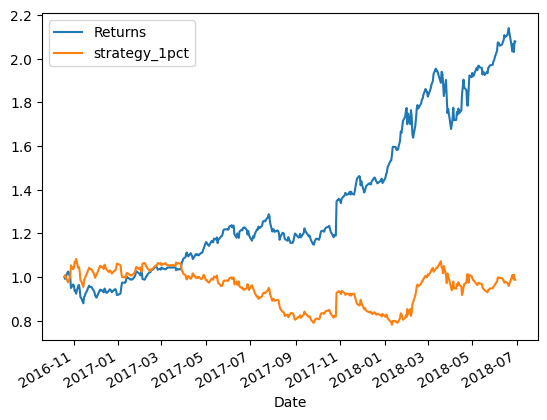

In [64]:
AMZN_Test[['Returns', 'strategy_1pct']].cumsum().apply(np.exp).plot()

## GS

In [70]:
GS_Train = GS[:int(len(GS) * 0.8)]
GS_Test = GS[int(len(GS) * 0.8):]

In [71]:
# to find the best order (p, d, q)
bestmodel = auto_arima(GS_Train, seasonal=False, trace=True).order

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7941.907, Time=1.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7946.862, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7942.513, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7942.633, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7944.863, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7940.247, Time=0.63 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=7944.465, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7940.167, Time=0.68 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7940.306, Time=0.79 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7944.369, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=7938.169, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=7940.635, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=7940.515, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=7938.308, Time=0.42 sec
 ARIMA(1,1,2)(0,0,0)[0]          

In [72]:
pre_GS = get_pre(GS, (0,1,1))

In [73]:
pre_GS

[169.08026492680762,
 172.41620328527173,
 174.38545109219484,
 174.50258982738717,
 174.66003555884842,
 175.09262593679057,
 175.52278981662178,
 176.97806223458912,
 177.70422794917476,
 177.1734871981929,
 178.17664432570254,
 178.06692999597308,
 176.6683379818233,
 176.23719467900867,
 175.93881842991908,
 181.1502419385578,
 181.87462679416504,
 192.00609759134255,
 200.43817360019472,
 203.77909966926254,
 208.94036332484976,
 211.0928193035949,
 206.47440158380456,
 209.48602861701795,
 210.31072890539585,
 211.04506222964386,
 211.1070509549178,
 212.25537982028143,
 211.4198239704645,
 210.39858971885687,
 211.688444216557,
 218.95047197050906,
 226.32849240484234,
 223.48265018698643,
 228.33366756243296,
 231.25416403739064,
 235.38715822603123,
 241.2209188728539,
 241.82648158464764,
 237.34626698247274,
 238.50393507178586,
 239.87551156788703,
 242.88187074834465,
 239.05480856786113,
 239.06940954566193,
 242.9333399405019,
 241.4988817992803,
 240.17421623723064,
 24

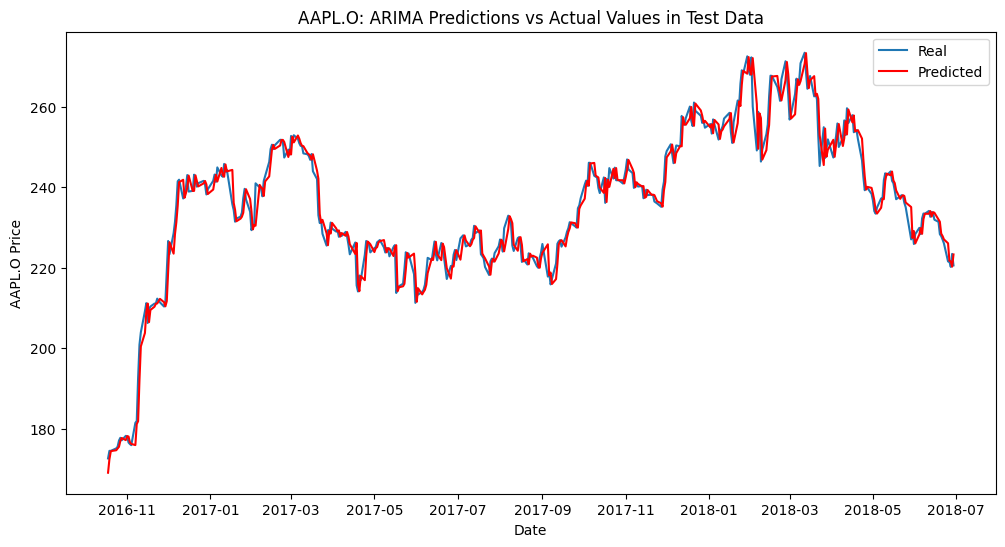

In [74]:
# Compare the test data with predictions
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(GS_Test, label='Real')
plt.plot(GS_Test.index, pre_GS, color='red', label='Predicted')
plt.title('AAPL.O: ARIMA Predictions vs Actual Values in Test Data')
plt.xlabel('Date')
plt.ylabel('AAPL.O Price')
plt.legend()
plt.show()

In [75]:
GS_Test = pd.DataFrame(GS_Test.dropna())
GS_Test['Returns'] = np.log(GS_Test['GS.N'] / GS_Test['GS.N'].shift(1))
GS_Test['direction'] = np.sign(GS_Test['Returns']).dropna().astype(int)
GS_Test['prediction']= pre_GS

In [76]:
signals = generate_signals(pre_GS)
GS_Test['signals'] = signals

In [78]:
GS_Test['strategy'] = GS_Test['signals'] * GS_Test['Returns']
GS_Test[['Returns', 'strategy']].sum().apply(np.exp)

Returns     1.277704
strategy    0.955608
dtype: float64

In [79]:
signals_1pct = generate_signals(pre_GS, 0.01)
GS_Test['signals_1pct'] = signals_1pct
GS_Test['strategy_1pct'] = GS_Test['signals_1pct'] * GS_Test['Returns']
GS_Test[['Returns', 'strategy_1pct']].sum().apply(np.exp)

Returns          1.277704
strategy_1pct    0.851589
dtype: float64

<Axes: xlabel='Date'>

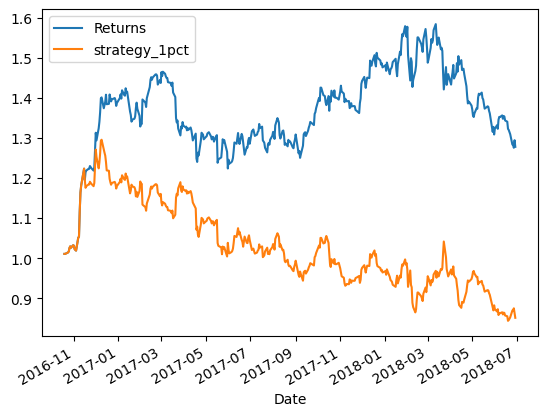

In [80]:
GS_Test[['Returns', 'strategy_1pct']].cumsum().apply(np.exp).plot()